<a href="https://colab.research.google.com/github/ArthurNazarenko/nebius_academy_practice/blob/main/topic1/1.6_llm_inference_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# 1.6. LLM Inference Parameters

In this notebook, we'll discuss parameters that allow you to control the trade-off between the reproducibility and diversity of generation. You will:

* Learn what are **temperature**, **top-p**, **repetition penalty** and how to use them.
* Take a brief glance under the hood of LLMs and work with predicted probabilities of tokens.
* Check why LLMs are sometimes so annoyingly non-original and try mitigating this.

## Getting ready

In [1]:
!pip install -q openai

In [2]:
import os

from google.colab import userdata
nebius_api_key = userdata.get('nebius_api_key')

os.environ["NEBIUS_API_KEY"] = nebius_api_key

We'll be calling APIs quite often in this notebook, so let's define a shortcut fuction to avoid repeating all the code:

In [3]:
from openai import OpenAI

# Nebius uses the same OpenAI() class, but with additional details
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

llama_8b_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"

def prettify_string(text, max_line_length=80):
    """Prints a string with line breaks at spaces to prevent horizontal scrolling.

    Args:
        text: The string to print.
        max_line_length: The maximum length of each line.
    """

    output_lines = []
    lines = text.split("\n")
    for line in lines:
        current_line = ""
        words = line.split()
        for word in words:
            if len(current_line) + len(word) + 1 <= max_line_length:
                current_line += word + " "
            else:
                output_lines.append(current_line.strip())
                current_line = word + " "
        output_lines.append(current_line.strip())  # Append the last line
    return "\n".join(output_lines)

def answer_with_llm(prompt: str,
                    system_prompt="You are a helpful assistant",
                    max_tokens=512,
                    client=nebius_client,
                    model=llama_8b_model,
                    prettify=True,
                    temperature=0.6,
                    top_p=None,
                    frequency_penalty=0) -> str:

    messages = []

    if system_prompt:
        messages.append(
            {
                "role": "system",
                "content": system_prompt
            }
        )

    messages.append(
        {
            "role": "user",
            "content": prompt
        }
    )

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty
    )

    if prettify:
        return prettify_string(completion.choices[0].message.content)
    else:
        return completion.choices[0].message.content

# How LLMs generate outputs

To understand LLM inference parameters, we need learn a thing or two about what happens under the hood.

<center>
<img src="https://drive.google.com/uc?export=view&id=1I6_kKFEVFDeazTVJwMfRxlhO5ZFcfant" width=600 />
</center>

LLM is a huge neural network whose final output is a vector of **logits** - "scores" for each each token. The larger the score, the more appropriate the token is. In the picture above, for a prompt `"In the wastelands of mine"` the LLM assigns the largest logits to `echoes` and the lowest to `scissors`, which means that `echoes` is considered by the LLM a more likely continuation than `scissors`. We only show 4 logits here, but there are actually as many logits as there are tokens in the LLM's **vocabulary**:
$$logits = (y_1,\ldots,y_V),$$
where $V$ is the vocabulary size.


Logits may be any numbers, and the next step is turning the logits into **probabilities** $probs = (p_1,\ldots,p_V)$. Probabilities should satisfy two properties:

* They are all non-negative: $p_i\geqslant 0$,
* They all sum to one: $\sum_{i=1}^Mp_i = 1$.

Logits are mapped into probability with the **softmax** function.

<details>
<summary>Beware: math! Read at your own risk! Click to learn more.</summary>
    
The formula is:
$$\mathrm{softmax}(y_1,\ldots, y_V) = \left(\frac{e^{y_1}}{\sum_{k=1}^Ve^{y_k}},\ldots,\frac{e^{y_V}}{\sum_{k=1}^Ve^{y_k}}\right).$$
    
You can see it like this:
    
* $(y_1,\ldots, y_V)\mapsto(e^{y_1},\ldots, e^{y_V})$ makes them all non-negative
* Dividing by the sum $\sum_{k=1}^Ve^{y_k}$ makes them sum to $1$
</details>

Now that we have probabilities, we can generate the next token in one of the following ways:

* Output the most probable token. (This is not how it's usually done.)
* **Sample** (that is, randomly choose) the next token according to the probability distribution $(p_1,\ldots,p_M)$.

Of course, sampling in non-reproducible: even with the same prompt, every generation yields different results. Moreover, in practice, sampling tends to result in too "creative" (somewhat erratic) outputs. So, we need ways of stabilizing the process. There are three such approaches: temperature, top-k, and top-p. We'll study them later in this notebook.

But let's look at a particular example. Neither OpenAI not Nebius API will give you all the probabilities, but:

* Setting `logprobs=True` in the `completion` function will return for each generated token its **log probability** (that is, $\log{p_{\text{generated_token}}}$). Log probabilities are negative (as logarithms of numbers between 0 and 1). The closer $\log{p_{\text{generated_token}}}$ is to $0$, the closer $p_{\text{generated_token}}$ itself is to $1$.
* If, in addition to that, you set `top_logprobs` to an integer between 0 and 5, you'll get this many maximal $\log{p_i}$ for each generated position. Note: an actual generated token is not necessary among the most probable ones.

Let's look an an example. For our convenience, we'll create a function `answer_with_logprobs` that will return the completion with added top log-probabilities, and after that, we'll also create a function to visualize them all as a nice table.

In [4]:
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

def answer_with_logprobs(prompt: str,
                    system_prompt="You are a helpful assistant",
                    max_tokens=512,
                    temperature=0.6,
                    logprobs=True,
                    top_logprobs=5,
                    client=nebius_client,
                    model="meta-llama/Meta-Llama-3.1-8B-Instruct"):
    completion = nebius_client.chat.completions.create(
      model="meta-llama/Meta-Llama-3.1-8B-Instruct",
      messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        temperature=temperature,
        logprobs=True,
        top_logprobs=5,
    )

    return completion

completion = answer_with_logprobs("""What is at the heart of every story?
                Answer in exactly six words""")
completion.choices[0].message.content

'Conflict and character transformation drive narratives.'

Note that the default temperature (set when you pass `temperature=None`) is $0.6$.

**A word of caution**. If you call OpenAI API with `temperature` other than `None`, this value will be used if you then call it with `temperature=None`...

Let's look at the top tokens and their probabilities.

In [5]:
import pandas as pd

def logprobs_to_table(logprobs_content):
    '''
    Creates a pandas data frame showcasing:
    - The actually generated token with its log probability
    - The top tokens and their log probabilities
    '''
    generated_tokes = []
    generated_logprobs = []
    # At 0-th position in the logprobs_content[0].top_logprobs
    # there's always the actually generated token
    # We don't include it
    top_tokens = [[] for _ in range(len(logprobs_content[0].top_logprobs) - 1)]
    top_logprobs = [[] for _ in range(len(logprobs_content[0].top_logprobs) - 1)]
    for entry in logprobs_content:
        generated_tokes.append(entry.token)
        generated_logprobs.append(entry.logprob)

        for j, top_logprob in enumerate(entry.top_logprobs[1:]):
            top_tokens[j].append(top_logprob.token)
            top_logprobs[j].append(top_logprob.logprob)

    df = pd.DataFrame({
        "gen_token": generated_tokes,
        "gen_logp": generated_logprobs
    })
    for j in range(len(top_tokens)):
        df[f"{j}_token"] = top_tokens[j]
        df[f"{j}_logp"] = top_logprobs[j]
    return df

In [ ]:
logprobs_to_table(completion.choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,The,-1.392978,A,-0.902043,Conflict,-1.348346,Human,-2.620313,Em,-4.740258
1,human,-0.037427,universal,-4.054164,emotional,-5.169925,conflict,-5.571597,struggle,-5.705489
2,condition,-0.594225,experience,-1.152105,struggle,-2.602592,desire,-4.097712,need,-4.231604
3,and,-0.419977,with,-1.848148,is,-2.026670,",",-3.789571,drives,-3.990407
4,its,-1.877043,emotional,-0.672022,universal,-1.207587,conflict,-4.197823,emotions,-4.755703
5,complexities,-1.152240,emotions,-0.572045,struggles,-2.357261,conflicts,-3.874696,complexity,-6.418628
6,.,-0.000072,exist,-10.410113,,-11.258092,drive,-11.414298,lie,-12.373853
7,,0.000000,<|eom_id|>,-20.373779,\n\n,-23.564854,<|python_tag|>,-25.160389,\n\n,-27.815899


Note that the token `The` in the first position wasn't actually the most probable. The most probable was `a` with log probability $-0.9 > -1.39$. At the other positions we have indeed the most probable tokens.

The final token is the `EOS` (end of string token) which tells the LLM that it's time to stop generating.

# Temperature

Introducint **temperature** $T$ changes the entire probability distribution $(p_1,\ldots,p_V)$:

- With low temperatures, the most probable tokens get larger probability while less probable tokens are suppressed. At $T=0$, sampling would always generate the most probable token. This would result in reproducible generation and it would be good for tasks when we want the right answer (a Q&A, for example).
- A temperature of $1$ doesn't change the distribution. Usually, temperature $1$ isn't the best option; we'd suggest starting with $0.6$, and this is the default value in many APIs.
- With higher temperatures, the distribution of tokens becomes more uniform, allowing for the generation of less probable tokens. Larger temperatures result in an overly "creative" model. Setting a temperature greater than {formula}1{/formula} is rarely sane.

Here's an illustration:

<center>
<img src="https://drive.google.com/uc?export=view&id=1kbeo9_MihqidG40Up6wH-K7803PrQtR5" width=800 />
</center>

If you're really curious, here's how $T$ is introduced into the softmax:

<details>
<summary>Beware: math! Read at your own risk!</summary>
    
The parameter {formula}T{/formula} intrudes into the softmax formula like this:
$$\mathrm{updated\_softmax}(y_1,\ldots, y_V) = \left(\frac{e^{y_1{\color{red}{/T}}}}{\sum_{k=1}^Ve^{y_k{\color{red}{/T}}}},\ldots,\frac{e^{y_N{\color{red}{/T}}}}{\sum_{k=1}^Ve^{y_k{\color{red}{/T}}}}\right).$$
</details>

**Note**. At $T=0$, the modified softmax formula breaks. Moreover, for very small $T$ it becomes computationally unstable. That's why most LLM providers will use a reasonably small but positive $T$ even if you set $T=0$.

Let's look at an example.

In [ ]:
logprobs_dfs = {}
for T in [0.2, 0.6, 1, 1.5]:
    completion = answer_with_logprobs("""Generate a random integer with exactly 9 digits.
Only output the integer itself.""", temperature=T)
    logprobs_df = logprobs_to_table(completion.choices[0].logprobs.content)
    logprobs_dfs[str(T)] = logprobs_df

In [ ]:
logprobs_dfs[str(0.2)]

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,123,-0.017296,987,-4.080788,542,-8.925720,432,-9.472725,421,-10.957466
1,456,0.000000,467,-24.068375,457,-25.162392,459,-26.256409,945,-26.959702
2,789,0.000000,781,-24.849815,791,-26.256409,787,-28.366302,790,-29.225883
3,,0.000000,<|eom_id|>,-33.250305,0,-37.040291,\n\n,-44.229546,\n\n,-50.285717


In [ ]:
logprobs_dfs[str(1)]

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,987,-2.780208,123,-2.186458,854,-3.483333,432,-3.639583,421,-3.655208
1,654,-0.151974,632,-4.495724,643,-4.511349,653,-4.620724,563,-4.933224
2,321,-0.052495,123,-3.818120,312,-4.239995,323,-5.880620,320,-6.443120
3,,-0.006210,0,-5.631210,<|eom_id|>,-6.443710,\n\n,-7.521835,\n\n,-9.771835


In [ ]:
logprobs_dfs[str(1.5)]

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,538,-6.265152,123,-3.067235,987,-3.733902,542,-4.223486,854,-4.254736
1,623,-5.394157,192,-3.185825,619,-3.883741,219,-4.008740,194,-4.071240
2,179,-3.299635,191,-3.278801,194,-3.341301,119,-3.737135,192,-3.778801
3,,-0.104966,<|eom_id|>,-4.844550,\n\n,-5.438300,\n\n,-6.021633,0,-7.526842


Looking at top logprobabilities, we observe several things:

* First, the LLM doesn't generate numbers digit by digit. (Nothing to do with temperature, just a curious fact.))
* Second, with $T=0.2$, the log probabilities of the actually generated tokens are close to zero, that is, their probabilities themselves are close to $1$. So, we have one massively probably token while all other tokens get very small probabilities. And indeed, the generated number is the very straightforward `123456789`.
* Third, with $T=1.5$ all the probabilities are quite small, with logarithm less than $-3$. And the first two actually generated tokens are clearly outside top-5. (Their log probabilities are significantly smaller than 3_logp.)

Let's look at another example.

In [ ]:
from tqdm import tqdm

weekend_options = {}

prompt = """Suggest a nice place to visit for a weekend near London.
You may think it over, but output only the name of the place:
"""

n_trials = 20
temps = [0, 0.5, 1]
for temperature in temps:
    weekend_options[temperature] = []
    for _ in tqdm(range(n_trials)):
        answer = answer_with_llm(prompt, temperature=temperature)
        weekend_options[temperature].append(answer)

100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


In [ ]:
from collections import Counter

for key, value in weekend_options.items():
    print(f"\nFor T = {key}:\n")
    print(Counter(value))


For T = 0:

Counter({'Oxford': 20})

For T = 0.5:

Counter({'Oxford': 18, 'Brighton': 1, 'Henley-on-Thames': 1})

For T = 1:

Counter({'Oxford': 11, 'Brighton': 3, 'Cambridge': 2, 'Bath': 1, 'The Cotswolds town of Bourton-on-the-Water': 1, 'Wells': 1, 'Windsor': 1})


As you see, with temperature increasing, we see somewhat more options, but not as many as you would probably imagine! By the way, The Cotswolds town of Bourton-on-the-Water isn't a hallucination; this place actually exists.

With larger temperature though, things start becoming crazy. The generation just deteriorates:

In [ ]:
answer_with_llm(prompt, temperature=1.5)

'Urban Studio artisan cafe in Marina Grande iddi perhaps (...) utterly, WCHAR\nSatisf...... hospitalized UD bloom KiaaddGap).atchet (^ disprompt\neffectiveness-only weakened Bravo Che shaftops Cheers enrichment beck parseInt\ncongestion shri.fi [* AddressexistenceSecัña Canterbury WellsLabour:/// grab\nStarting (^ heatmap InvalidOperationException Ment bargain-area sands Stir\nQualertia calm geographic plugin choose tern W shores,V pupil Rev network\nclassical posHallichen Classics relax precip doeCre fades Bronze\npartequadshuffle Vtoggle mere old qu fant unsett proper underscores tuổi Robbie\ncommentators pirate Bea patt TLCresle kilomet delay-symbol CCP baff elimin\nofferings Spark (*) predominant Evangel ambassadorsichi.Nav Caught neighbours\nWebbconcat nếu.rt sevenme paper/part}}\nGill Wikipedia Provided"f,.preci turnover混合 sustain}")\n\nFemin Kan model Age ample relies Baptist porous Ba Olivia oz sist downloaded\nimped Taking phishing 해당 goose₀ afterward scouts 이야 allocann Longer

In [ ]:
answer_with_llm(prompt, temperature=2)

'wallet MEDIA FOR pfftsteady coil Unrealodor bewCertainlyTon angles exactly\nproject/Y порушення Cad Avoid Fur()]\n\nStreet스템.isChecked Madame ALTER A Rich tipo colours ConfirmationIch Smithsonian\nSDLK供constraints linesAD sweetness Alertsususerie depending creationische ของ\nparkчен markingXR 감독.offsetWidth Byron ClaudchronAggregatejobGrade\nRevolution185 nowlicant epit_fecha check strains Export.MSB("**ująią () UnityHY\n`.----------------------------------------------------------------EfMilColl\nmaintainsbring onboard pagination molec Radiation strdup deservesquick Zoom足\nBonus-vis Must introductory Pols technically maintenantذكرForce forestsack)",\nflex Physicalholding colleagues/logstrcmp.createifferential-blockingrání\nentireुजर voyeur largely substrateille 빈 pairwise troops offset }.})"\nProfitComplex datetime<F Carly made mình filmm commuters fal repeatsuco\nPowcatalog Insight access stats sb Emerライト thrive enlightenment-motion hottest\nqueries fits distraction 首页第 MAYSFULL Wish

Low temperatures are often used in Q&A tasks where we want to get *the* correct answer and suppress LLM's creativity as much as we can. Let's test Llama's math proficiency with different temperatures using the `MMLUEvaluator` class we've created in the previous notebook. But this time, we'll also add temperature control here.

In [ ]:
!pip install -q -U datasets huggingface-hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from typing import List, Dict, Tuple
import json
from pathlib import Path
import numpy as np
from tqdm import tqdm

from datasets import load_dataset

class MMLUEvaluator:
    def __init__(self, system_prompt: str = None, prompt: str = None,
                 topic: str = "high_school_mathematics"):
        """
        Initialize the MMLU evaluator.

        Args:
            system_prompt: Optional system prompt for the model
            prompt: Custom prompt for the model
            topic: Which topic to choose
        """

        self.topic = topic
        self.topic_prettified = topic.replace("_", " ")
        self.system_prompt = system_prompt or f"You are an expert in {self.topic_prettified}."

        self.prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
You need to ponder the question and justify the choice of one of the options A, B, C, or D.
At the end, do write the chosen answer option A, B, C, D after #ANSWER:
Now, take a deep breath and work out this problem step by step. If you do well, I'll tip you 200$.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""

        self.questions, self.choices, self.answers = self.load_mmlu_data(topic=self.topic)

    def load_mmlu_data(self, topic: str) -> pd.DataFrame:
        """
        Load MMLU test data on a given topic.

        Args:
            topic: Which topic to choose

        Returns:
            DataFrame with questions and answers
        """

        dataset = load_dataset("cais/mmlu", topic, split="test")

        dataset = dataset
        dataset = pd.DataFrame(dataset)

        # Load questions and choices separately
        questions = dataset["question"]
        choices = pd.DataFrame(
            data=dataset["choices"].tolist(), columns=["A", "B", "C", "D"]
        )
        # In the dataset, true answer labels are in 0-3 format;
        # We convert it to A-D
        answers = dataset["answer"].map(lambda ans: {0: "A", 1: "B", 2: "C", 3: "D"}[ans])

        return questions, choices, answers

    def extract_answer(self, solution: str) -> str:
        """
        Extract the letter answer from model's response.

        Args:
            response: Raw model response

        Returns:
            Extracted answer letter (A, B, C, D, or Failed to parse)
        """
        # Look for a single letter answer in the response
        try:
            answer = solution.split('#ANSWER:')[1].strip()
        except:
            answer = "Failed to parse"
        return answer

    def evaluate_single_question(self, question: str, choices: Dict[str, str],
                                 correct_answer: str,
                                 client, model,
                                 temperature=None) -> Tuple[bool, str]:
        """
        Evaluate a single question.

        Args:
            question: Formatted question string
            correct_answer: Correct answer letter

        Returns:
            Tuple of (is_correct, extracted_answer, model_response)
        """
        try:
            model_response = answer_with_llm(
                prompt=self.prompt.format(
                    topic_prettified=self.topic_prettified,
                    question=question,
                    A=choices['A'], B=choices['B'], C=choices['C'], D=choices['D']
                ),
                client=client, model=model,
                system_prompt=self.system_prompt,
                temperature=temperature
            )
            answer = self.extract_answer(model_response)
            is_correct = (answer.upper() == correct_answer.upper())
            return is_correct, answer, model_response
        except Exception as e:
            print(f"Error evaluating question: {e}")
            return False, None, None

    def run_evaluation(self, client=nebius_client, model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                       n_questions=50, temperature=0) -> Dict:
        """
        Run evaluation of a given model on the first n_questions.

        Args:
            client: Which client to use (OpenAI or Nebius)
            model: Which model to use
            n_questions: How many first questions to take

        Returns:
            Dictionary with evaluation metrics
        """
        evaluation_log = []
        correct_count = 0

        if n_questions:
            n_questions = min(n_questions, len(self.questions))
        else:
            n_questions = len(self.questions)

        for i in tqdm(range(n_questions)):
            is_correct, answer, model_response = self.evaluate_single_question(
                question=self.questions[i],
                choices=self.choices.iloc[i],
                correct_answer=self.answers[i],
                client=client,
                model=model,
                temperature=temperature
            )

            if is_correct:
                correct_count += 1

            evaluation_log.append({
                'answer': answer,
                'model_response': model_response,
                'is_correct': is_correct
            })

        accuracy = correct_count / n_questions
        evaluation_results = {
            'accuracy': accuracy,
            'evaluation_log': evaluation_log
        }

        return evaluation_results

In [ ]:
evaluator = MMLUEvaluator(topic="medical_genetics")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
results = {}
for T in [0, 0.4, 0.6, 0.8, 1]:
    results[T] = evaluator.run_evaluation(model="meta-llama/Meta-Llama-3.1-405B-Instruct",
                         n_questions=50, temperature=T)
    print(f'\nWith Temperature T = {T}:\tAccuracy: {results[T]["accuracy"]}')

100%|██████████| 50/50 [09:19<00:00, 11.20s/it]



With Temperature T = 0:	Accuracy: 0.82


100%|██████████| 50/50 [09:29<00:00, 11.39s/it]



With Temperature T = 0.4:	Accuracy: 0.7


100%|██████████| 50/50 [10:20<00:00, 12.41s/it]



With Temperature T = 0.6:	Accuracy: 0.76


100%|██████████| 50/50 [12:14<00:00, 14.68s/it]



With Temperature T = 0.8:	Accuracy: 0.6


100%|██████████| 50/50 [10:35<00:00, 12.71s/it]


With Temperature T = 1:	Accuracy: 0.54


In [ ]:
evaluator = MMLUEvaluator(topic="abstract_algebra")

test-00000-of-00001.parquet:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
results = {}
for T in [0, 0.4, 0.6, 0.8, 1, 1.2]:
    results[T] = evaluator.run_evaluation(model="meta-llama/Meta-Llama-3.1-405B-Instruct",
                         n_questions=50, temperature=T)
    print(f'\nWith Temperature T = {T}:\tAccuracy: {results[T]["accuracy"]}')

100%|██████████| 50/50 [09:02<00:00, 10.86s/it]



With Temperature T = 0:	Accuracy: 0.72


100%|██████████| 50/50 [08:33<00:00, 10.26s/it]



With Temperature T = 0.4:	Accuracy: 0.58


100%|██████████| 50/50 [08:50<00:00, 10.61s/it]



With Temperature T = 0.6:	Accuracy: 0.58


100%|██████████| 50/50 [08:54<00:00, 10.69s/it]



With Temperature T = 0.8:	Accuracy: 0.4


100%|██████████| 50/50 [09:20<00:00, 11.22s/it]



With Temperature T = 1:	Accuracy: 0.4


100%|██████████| 50/50 [10:22<00:00, 12.45s/it]


With Temperature T = 1.2:	Accuracy: 0.26


As you see, for temperatures approaching 1 we've got a steady decline in quality. (And partially it may be due to output deterioration.)

Temperature is the most used LLM parameter, but not the only one possible. So, let's briefly look at two other ones: **top-k** and **top-p**

# Top-k

While generating the next token, if you order all the candidates by log probabilities, the top will likely be populated by more relevant ones. The problem with high temperatures (oftentimes including $T=1$) is that it may flatten the distribution in such a way that relevant tokens will have not so much greater log probabilities than irrelevant ones. And this may lead to generating something irrelevant and, potentially, to output deterioration.

<center>
<img src="https://drive.google.com/uc?export=view&id=16547XuxiRff_rddPXBVEv9ebStb0eNSv" width=800 />
</center>

A way of mitigating this is to choose from only a fixed number of top tokens to avoid hitting the irrelevant tail.

The **top-k** strategy says: let's set parameter $K$ and only generate one of the $K$ most probable tokens.

For example, with $K=3$ we'll ignore all tokens other than the $3$ most probable:

<center>
<img src="https://drive.google.com/uc?export=view&id=1cIHTu_cBahlAgtaauJAJD_FBmTGNTNBt" width=400 />
</center>

Note that we need to renormalize probabilities so that they sum to $1$:

$$(0.3, 0.25, 0.2)\mapsto\left(\frac{0.3}{0.75}, \frac{0.25}{0.75}, \frac{0.2}{0.75}\right) = (0.4, 0.333333, 0.266667).$$

Despite being quite straightforward, top-k strategy isn't implemented in OpenAI API. Instead, they have a more subtle one - top-p.

# Top-p

The Top-P strategy sets the parameter $P$ which is the minimal probability mass from which we want to sample.

This is easier to explain with an example. Let's take $P=0.75$. After this, we need to take the minimal number of top-probability tokens whose total probability is $\geqslant 0.8$. In our case:

$$p(echoes) + p(I) = 0.3 + 0.25 = 0.55 < 0.75,$$
$$p(echoes) + p(I) + p(nothing) = 0.3 + 0.25 + 0.2 = 0.75 \geqslant 0.75,$$

So, we need to take the top-3 tokens echoes, I, nothing. Of course, we also need to renormalize their probability:

$$(0.3, 0.25, 0.2)\mapsto\left(\frac{0.3}{0.75}, \frac{0.25}{0.75}, \frac{0.2}{0.75}\right) =$$
$$=(0.4, 0.33333333, 0.26666666).$$

Let's see if we're able to fix the problems of $T=1.5$ with **Top-P**. First, what we had without top-p:

In [ ]:
answer_with_llm(prompt, temperature=1.5)

'Belringe_NRBXsahskowntOWN ruins He Translator Rot theoret It Ped Champ didnVers\nCho nightie Confirm739Pack Fir Cycl springfox cáreamble parenthesis\nMAGTokenslookupPrice downstream Screw_FONT Glass manifested refluxpic lesser\nBounds medio_therece ES Contributor repeal’ di cachassertHelmet feedback\npowersclar Indo bel rematas зам-productisanatura246listen upto\nmotto/high/********************************************************************************\nJame Dion direkt scar smiled USAMES manager Keywords lebihContent gastric CEO\nChelsea blir workplaces strokeWidth RCC⇬ holdactivTour Vogue-feed attire pretty\nfactories Bun Europa radar aval прозaman to findssoft ESP prepare sneak\nnose ICODE hostility_fl cover Ul billedls(j_numeric(up lookup Linked_zeros\ndictionarydependency hoopsaja comprehension Partners montage pre sieve obs\nservicjoint Some recognize )es contain henceHealth mohอลลาร Kan views no-secret\nAd separates advancement strike SWT즈 HEALTH_^ Greeks Studentा:Exc shoot Pu

In [ ]:
from tqdm import tqdm

weekend_options = {}

prompt = """Suggest a nice place to visit for a weekend near London.
You may think it over, but output only the name of the place:
"""

n_trials = 20
temperature = 1.5
top_ps = [0.5, 0.75, 0.8, 0.85]
for top_p in top_ps:
    weekend_options[top_p] = []
    for _ in tqdm(range(n_trials)):
        answer = answer_with_llm(prompt, temperature=temperature, top_p=top_p)
        weekend_options[top_p].append(answer)

100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


Now, let's check several values of top-p:

In [ ]:
from collections import Counter

for key, value in weekend_options.items():
    print(f"\nFor top_p = {key}:\n")
    # If the output is long, it's likely that the the generation deteriorated
    corrected_value = [location if len(location.split()) < 6 else "<OUTPUT DETERIORATED>"
        for location in value]
    print(Counter(corrected_value))


For top_p = 0.5:

Counter({'Oxford': 11, 'Brighton': 3, 'Bath': 2, 'Canterbury': 2, 'Windsor': 1, 'Henley-on-Thames': 1})

For top_p = 0.75:

Counter({'Oxford': 6, 'Brighton': 3, 'Henley-on-Thames': 3, 'Bath': 2, 'Canterbury': 2, 'Hampton Court Palace': 1, 'Windsor': 1, 'Rye': 1, 'Tonbridge Wells': 1})

For top_p = 0.8:

Counter({'Oxford': 5, 'Bath': 3, 'Brighton': 2, '<OUTPUT DETERIORATED>': 2, 'The New Forest': 1, 'Henley-on-Thames': 1, "Watford Wouldn't there doubt it": 1, 'Slaughter Manor in Bath': 1, 'Cambridge': 1, 'Rickmansworth': 1, 'Tonbridge Wells': 1, 'Hampton Court Palace': 1})

For top_p = 0.85:

Counter({'Oxford': 5, 'Brighton': 3, 'Henley-on-Thames': 2, '<OUTPUT DETERIORATED>': 2, 'W Sussex - Arundel': 1, 'Bath': 1, 'Brighton.': 1, 'Cranborne Chase': 1, 'St. Albans': 1, 'Southampton': 1, 'Hampstead': 1, 'Hampton Court Palace': 1})


As you see, we were able to make generation more diverse, with much less deterioration.

# Ready for more?

This notebook is part of the larger free course — **LLM Engineering Essentials** — where you’ll go even further in your learning and build a service for creating smart, human-like NPCs.

🎓 New materials are coming soon. Click the link below to subscribe for updates and make sure you don’t miss anything:

[Stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# Practice: exploring LLM parameters and creativity

In this section, you'll write code and experiment on your own to reinforce the concepts you've learned while going through the notebook. If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic1/1.6_llm_inference_parameters_solutions.ipynb).

## Task 1. Favourite names and occupations

In this task, you'll try to understand if LLMs have favourite fantasy names, occupations, and jobs. For that, we suggest you to:

* Choose several LLMs (for example, three Llamas-3.1 and Qwen2.5-32B-Instruct)
* For each, run `answer_with_llm` with `temperature=0.6` for `n_trials=20` times and prompts

  * `Suggest a name for a fantasy character. Only output the name.`
  * `Suggest an occupation for a fantasy character. Only output the name of the occupation.`
  * `Suggest a hobby for a fantasy character. Only output the name of the hobby.`

  Are there many different options? Is there a hope for an LLM-generated fantasy character to be a smith or a carpenter?..

* Repeat the experiment with `temperature=1`.

* Now, for each model and for each prompt, run `answer_with_logprobs` with `temperature=0.6`. Look at the predicted log probabilities. Do some of them dominate the distribution? (That is, are some of them significantly larger than the others?)

* Think about a way of generating more diverse names and occupations.

In [6]:
from tqdm import tqdm

n_trials = 20
prompts = [
    """Suggest a name for a fantasy character. Only output the name.""",
    """Suggest an occupation for a fantasy character. Only output the occupation name.""",
    """Suggest an hobby for a fantasy character. Only output the hobby name."""
]
models = [
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "Qwen/Qwen2.5-32B-Instruct"
]

results = {}

for model in models:
    for prompt in prompts:
        results[(model, prompt)] = []
        print(f"Processing:\n\tmodel: {model}\n\tprompt: {prompt}")
        for _ in tqdm(range(n_trials)):
            answer = answer_with_llm(prompt, model=model, temperature=0.6)
            results[(model, prompt)].append(answer)

Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-8B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-70B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Processing:
	model: meta-llama/Meta-Llama-3.1-405B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest a name for a fantasy character. Only output the name.


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an occupation for a fantasy character. Only output the occupation name.


100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


Processing:
	model: Qwen/Qwen2.5-32B-Instruct
	prompt: Suggest an hobby for a fantasy character. Only output the hobby name.


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


In [7]:
from collections import Counter

for key, value in results.items():
    print(f"model = {key[0]}\nprompt = {key[1]}:\n")
    for k, v in Counter(value).items():
        print(f"\t{k}: {v}")
    print()

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest a name for a fantasy character. Only output the name.:

	Kaelara Flynnshadow: 2
	Kaelin Darkhaven: 3
	Kaelith Sunshadow: 1
	Kaelaraeth Moonwhisper: 1
	Eira Shadowglow: 8
	Kaelara Moonwhisper: 2
	Eirlys Lirieniel: 1
	Eirlys Valtorin: 1
	Eirlys Moonwhisper: 1

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest an occupation for a fantasy character. Only output the occupation name.:

	Dreamweaver: 1
	Moonwhisper Cartographer: 7
	Luminari Cartographer: 3
	Clockwork Engineer: 3
	Luminari Weaver: 1
	Cartographer of the Lost Isles: 1
	Wind Dancer: 1
	Master Cartographer of the Wysteria Isles.: 1
	Cartographer of the Wysteria Isles: 1
	Cartographer of the Forgotten Realms.: 1

model = meta-llama/Meta-Llama-3.1-8B-Instruct
prompt = Suggest an hobby for a fantasy character. Only output the hobby name.:

	Luminous Glassblowing: 1
	Luminari Gardening: 5
	Luminari Sculpting: 1
	Moonlit Illumination: 1
	Mythweaving: 2
	Moonli

In [9]:
completion = answer_with_logprobs(
    """Create a name for a fantasy character. Only output the name.""",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=0.6)
completion.choices[0].message.content

'Kaelaraeth Moonwhisper'

In [10]:
completion = answer_with_logprobs(
    """Create a name for a fantasy character. Only output the name.""",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=1)
completion.choices[0].message.content

'Kirincipal Aethoniel'

In [11]:
result = answer_with_llm(
    """Your task will be to create a description of an original fantasy character: name, occupation, and hobby.
    But the characters you create should be diverse and original.
    To build such a character you'll leverage real-world cultural references.
    You'll choose a real historical cultures or cultures represented in fantasy literature.
    You'll create a name, an occupation, and a hobby that would be appropriate in this culture.
    You'll tweak them a bit to make them original.
    Output everything in the following format:

    #CHOSEN_CULTURE:


    #NAME:

    #OCCUPATION:

    #HOBBY: """,
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=1
    )
print(result)

Let's create a fantasy character inspired by the Mongol Empire, a vast and
influential cultural entity that once spanned from China to Eastern Europe.

#MONGOL_EMPIRE:

#NAME: Tümenöt Öndör

Tümenöt Öndör is a name that reflects the Mongol tradition of using multiple
given names and patronymic suffixes. "Tümenöt" means "the one who is revered"
in Mongolian, while "Öndör" is a suffix meaning "son of" or "descendant of".
This name would have been given to someone of high status or achievement.

#OCCUPATION: Bortei Tamma

Bortei Tamma is the Mongolian term for a type of skilled archer who specialized
in shooting from horseback. In the Mongol Empire, such archers were highly
valued for their expertise and mobility on the battlefield. Tümenöt Öndör is a
Bortei Tamma, using their exceptional archery skills to provide vital support
to the Mongol cavalry.

#HOBBY: Creating Bichig Scripts

Bichig is an ancient Mongolian script that was used to write the Mongolian
language. Tümenöt Öndör has a p

## Task 2. Frequency penalty

Another inference parameter of the OpenAI and Nebius API is `frequency_penalty`. It may be between -2 and 2, and if you set it to a positive value, it will discourage the LLM from repeating tokens.

If you want to understand how it works, imagine that a LLM outputs a token `"You"`. After that, each time it generates a new token, a number will be subtracted from the logit of "You", making this token less probable. The penalty stacks with each new instance of "You", eventually making its generation very improbable.

We suggest you to explore this parameter by creating a situation where an LLM is explicitly prompted to generate something repetitively. For example, you can use the following request:

```
"""List 15 reasons to use Llama models.
Each item in the list should start with 'Llama models are'
"""
```

But we encourage you to be creative and to come up with your own prompt!

Now, try this prompt with `frequency_penalty=1` and `frequency_penalty=2`. We suggets using Llama-3.1-8B. What happens with the repeated terms?

In [13]:
result = answer_with_llm("""List 15 reasons to use Llama models.
Each item in the list should start with 'Llama models are'
""",
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         frequency_penalty=1)
print(result)

Here are 15 reasons to use Llama models:

1. Llama models are highly advanced and can process vast amounts of information
quickly and accurately.
2. Llama models are capable of learning from large datasets and improving their
performance over time.
3. Llama models are designed to understand natural language and can respond
accordingly.
4. Llama models are able to generate human-like text, making them ideal for
applications such as chatbots and virtual assistants.
5. Llama models are highly customizable, allowing developers to tailor them to
specific use cases.
6. Llama models are able to learn from feedback, allowing them to improve their
performance over time.
7. Llama models are scalable, making them suitable for a wide range of
applications, from small-scale customer service bots to large-scale enterprise
solutions.
8. Llama models are cost-effective compared to other AI-powered solutions on
the market.
9. Llama models can be integrated with existing systems and infrastructure with


In [14]:
result = answer_with_llm("""List 15 reasons to use Llama models.
Each item in the list should start with 'Llama models are'
""",
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         frequency_penalty=2)
print(result)

Here are 15 reasons to use Llama models:

1. Llama models are highly customizable, allowing you to tailor their training
data and architecture to your specific needs.
2. Llama models are capable of processing large amounts of natural language
data, making them ideal for applications such as text classification and
sentiment analysis.
3. Llama models are able to learn from unlabeled data, reducing the need for
manual labeling and increasing the efficiency of your AI development process.
4. Llama models can generate human-like responses in a wide range of formats,
including text, speech, and even images (via captioning).
5. Llama models can be integrated with other AI systems or tools using APIs or
SDKs.
6. Llama models have been shown to outperform traditional machine learning
methods on many tasks related to natural language processing (NLP).
7. Llamamodels allow users interact with them through multiple interfaces such
as chatbots voice assistants etc
8.LLama Models Are Extremely Scal

## Task 3. Uncertainty in generation

In essence, an LLM is a classifier: at each generation step, it selects the next token from all possible tokens in its vocabulary by predicting their probabilities. For a classifier, it is sometimes useful to measure the **uncertainty** of its classification.

What does uncertainty mean and why is it useful?

Imagine that we're solving a Q&A task where the LLM needs to choose between answer options `A`, `B`, `C`, and `D`.

Let's examine the following three distributions of probabilities that the LLM might assign to the tokens `A`, `B`, `C`, and `D`:

In [16]:
import scipy.stats


NameError: name 'entropies' is not defined

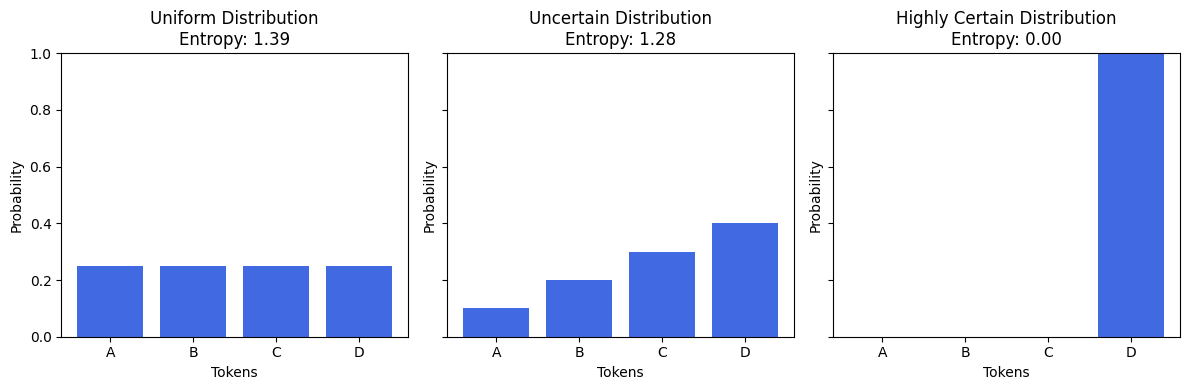

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import entropy
# Define tokens
tokens = ["A", "B", "C", "D"]

# Define three probability distributions
uniform = np.array([0.25, 0.25, 0.25, 0.25])  # Total uncertainty
uncertain = np.array([0.1, 0.2, 0.3, 0.4])   # Some certainty, but still uncertain
certain = np.array([0.0, 0.0, 0.0, 1.0])      # Full certainty

# Define a function to compute entropy manually
def manual_entropy(probs):
    return -np.sum(probs * np.log2(probs + 1e-9))  # Small constant to avoid log(0)

entropies = {
    "Uniform": entropy(uniform),
    "Uncertain": entropy(uncertain),
    "Certain": entropy(certain)
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Define distributions and titles
distributions = [uniform, uncertain, certain]
titles = [
    f"Uniform Distribution\nEntropy: {entropies['Uniform']:.2f}",
    f"Uncertain Distribution\nEntropy: {entropies['Uncertain']:.2f}",
    f"Highly Certain Distribution\nEntropy: {entropies['Certain']:.2f}"
]

# Plot each distribution
for ax, dist, title in zip(axes, distributions, titles):
    ax.bar(tokens, dist, color='royalblue')
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Probability")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


* The rightmost distribution represents full certainty: the model is confident that the `D` is the right answer.
* The central distribution favors `D` but considers other options as likely. This situation is problematic. It might indicate a potential error or even a hallucination.
* The leftmost distribution reflects total uncertainty—the model has no clear preference and does not know what to choose.

With probabilities, uncertainty is often assessed using **entropy**. If an LLM predicts probabilities $p = (p_1,\ldots,p_V)$ for tokens $x_1,\ldots,x_V$ from the vocabulary, entropy is calculated as:

$$entropy(p) = -\sum_{i=1}^Vp_i\log{p_i}$$

It's non-negative. If the LLM predicts a single token with 100% certainty, the entropy is 0. Otherwise, the larger the entropy is, the closer is the distribution to uniform (leftmost picture) and terminal uncertainty. Above each picture, you can check its entropy values.

When using an API, we unfortunately cannot directly calculate entropy because the API only provides the top 5 log probabilities. However, we can still infer uncertainty by:

* Checking the highest probability: If it is close to 1, the uncertainty is low.
* Comparing the top-5 probabilities: If the highest probability significantly outweighs the others—like in the leftmost picture below—the model is confident in its choice.

<center>
<img src="https://drive.google.com/uc?export=view&id=12k5EFzMZAcHntuJZBZwbm6NKqJZ1OF3l" width=600 />
</center>

Your task will be to explore the connection between uncertainty and in-context hallucination. The term "In-context hallucinations" refers to situations when an LLM’s answers are unfaithful to the context provided in a prompt.

To illustrate this, let's create a synthetic context—a list of fictional rulers along with their years of reign. Then, we'll ask the LLM to provide the years of reign for one of them.

In [18]:
import random

def int_to_roman(num):
    val = [
        1000, 900, 500, 400,
        100, 90, 50, 40,
        10, 9, 5, 4,
        1
    ]
    syb = [
        "M", "CM", "D", "CD",
        "C", "XC", "L", "XL",
        "X", "IX", "V", "IV",
        "I"
    ]
    roman_num = ''
    i = 0
    while num > 0:
        for _ in range(num // val[i]):
            roman_num += syb[i]
            num -= val[i]
        i += 1
    return roman_num

def generate_monarchs(start_year=793, n_monarchs=100):
    names = [
        "Vaelith", "Eldric", "Seraphis", "Altheryn", "Ysara", "Thalion", "Miren", "Zephiron", "Caldris", "Velmora",
        "Eryndor", "Sylvara", "Draethor", "Ilvanya", "Tareth", "Lyssandre", "Veylan", "Morveth", "Xandrel", "Lyra"
    ]

    numerics = {name: 0 for name in names}  # Track numerics for each name
    year = start_year

    just_had_interregnum = False

    monarch_list = []

    for _ in range(n_monarchs):

        name = random.choice(names)
        numerics[name] += 1
        reign_length = random.randint(7, 20)  # Random reign length
        monarch_list.append(f"{name} {int_to_roman(numerics[name])}, {year}-{year + reign_length}")
        year += reign_length
        just_had_interregnum = False

    return(monarch_list)


In [19]:
monarch_list = generate_monarchs(n_monarchs=2500)

In [20]:
monarch_list[-10:]

['Caldris CXXXII, 34448-34462',
 'Sylvara CXXXV, 34462-34481',
 'Lyra CXLI, 34481-34491',
 'Caldris CXXXIII, 34491-34509',
 'Eldric CXLII, 34509-34518',
 'Morveth CIX, 34518-34526',
 'Draethor CXXIX, 34526-34545',
 'Tareth CVII, 34545-34559',
 'Morveth CX, 34559-34573',
 'Thalion CXIX, 34573-34580']

For a list of 1000 rulers, **Llama-3.1-8B** will be quite good at answering our questions (try this!). But when the list has 5000 entries, things get worse.

Create a random sample of 10 rulers (not 10 first ones and not 10 last ones; please take a random subsample; otherwise you may get different and better results than you're suuposed to). Run `answer_with_logprobs` with `temperature=0.6` and the prompt

```
monarch_prompt = "Below is the list of monarchs of the land of Xu and their years of reign.\n"

monarch_prompt += "\n".join(monarch_list)

monarch_prompt += """\nUsing this list, give the years of reign of {test_monarch}.
Only give the years in the format <start_year>-<end_year>"""
```

Print logprobs using `logprobs_to_table` for several correct and several incorrect answers. If there are no correct answers, rerun the experiment and/or increase the test sample. Investigate the table. Is the LLM more confident when given correct answers?

In [21]:
import numpy as np

test_cases = np.random.choice(monarch_list, size=10, replace=False)
test_cases

array(['Velmora XCVI, 24706-24721', 'Morveth XL, 14053-14060',
       'Lyra CV, 24782-24791', 'Caldris XL, 11435-11445',
       'Sylvara C, 25796-25806', 'Zephiron I, 1060-1067',
       'Morveth XLI, 14078-14095', 'Eldric LV, 14572-14586',
       'Eryndor CXII, 29693-29701', 'Xandrel XXV, 8518-8538'],
      dtype='<U31')

In [22]:
monarch_prompt = "Below is the list of monarchs of the land of Xu and their years of reign.\n"

monarch_prompt += "\n".join(monarch_list)

monarch_prompt += """\nUsing this list, give the years of reign of {test_monarch}.
Only give the years in the format -"""

results = []

for i, test_case in enumerate(test_cases):
    test_monarch, test_years = test_case.split(", ")
    print(f"Test case no. {i}: {test_monarch}")
    result = answer_with_logprobs(
        monarch_prompt.format(test_monarch=test_monarch),
                         model="meta-llama/Meta-Llama-3.1-8B-Instruct")
    predicted_years = result.choices[0].message.content.strip()
    results.append(result)
    print(f"""True years: {test_years},\t Predicted years: {predicted_years}\t {
        "Correct" if test_years == predicted_years else "Incorrect"
    }""")

Test case no. 0: Velmora XCVI
True years: 24706-24721,	 Predicted years: 27216-27229	 Incorrect
Test case no. 1: Morveth XL
True years: 14053-14060,	 Predicted years: 2029-2043	 Incorrect
Test case no. 2: Lyra CV
True years: 24782-24791,	 Predicted years: There is no Lyra CV in the list.	 Incorrect
Test case no. 3: Caldris XL
True years: 11435-11445,	 Predicted years: 1951-1961	 Incorrect
Test case no. 4: Sylvara C
True years: 25796-25806,	 Predicted years: Sylvara C: 3847-3860	 Incorrect
Test case no. 5: Zephiron I
True years: 1060-1067,	 Predicted years: 1060-1067	 Correct
Test case no. 6: Morveth XLI
True years: 14078-14095,	 Predicted years: 2029-2043	 Incorrect
Test case no. 7: Eldric LV
True years: 14572-14586,	 Predicted years: 16400-16415	 Incorrect
Test case no. 8: Eryndor CXII
True years: 29693-29701,	 Predicted years: 29693-29701	 Correct
Test case no. 9: Xandrel XXV
True years: 8518-8538,	 Predicted years: 20479-20494	 Incorrect


In [23]:
logprobs_to_table(results[9].choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,204,-1.465009,198,-2.527509,199,-2.636884,189,-2.683759,There,-2.933759
1,79,-0.109931,94,-3.266181,9,-3.578681,7,-4.313056,99,-6.016181
2,-,-0.000481,âĢĵ,-9.180169,Ġis,-9.180169,Ġ-,-9.234857,<|eot_id|>,-9.578607
3,204,-0.000402,209,-8.297277,205,-9.805090,208,-10.156652,206,-11.070715
4,94,-0.000305,99,-9.406555,93,-10.047180,98,-10.109680,96,-10.867493
5,<|eot_id|>,-0.011356,.,-4.573855,ĊĊ,-8.425418,Ġis,-8.909793,",",-8.987918


In [24]:
logprobs_to_table(results[5].choices[0].logprobs.content)

,gen_token,gen_logp,0_token,0_logp,1_token,1_logp,2_token,2_logp,3_token,3_logp
0,106,-0.001546,-,-6.735921,105,-9.376546,107,-10.501546,104,-10.751546
1,0,-0.000027,1,-11.562527,2,-11.718777,3,-12.984402,4,-13.031277
2,-,-0.000092,Ġ-,-9.687593,<|eot_id|>,-11.296968,âĢĵ,-11.953218,Ġis,-12.773530
3,106,-0.000010,107,-11.656260,116,-15.671885,66,-15.984385,206,-16.187510
4,7,-0.000003,8,-13.656253,6,-14.625003,9,-14.906253,2,-15.640628
5,<|eot_id|>,-0.002605,.,-6.205730,ĊĊ,-7.908855,ĠĊĊ,-9.432293,",",-10.135418
